In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


**Friends S1E1 Character Positivity**

I, like a lot of people, love Friends! And I, like most people, have my favourite character (can you guess who?).

I would like to therefore find out if my favourite character is the most positive character in the show. However, to start with I am just going to consider the first episode.

**Data Input**

The data is currently a text file and I plan to turn it into a data frame consisting of a column of character names and a column of speech by that character. First, however, I am going to create a nested list and clean it before turning it into a data frame.

In [2]:
df = open('../input/friends-tv-series-screenplay-script/S01E01 Monica Gets A Roommate.txt', "r")
lines = df.readlines()
df.close()

# remove /n at the end of each line
for index, line in enumerate(lines):
      lines[index] = line.strip()
# print(lines)

#for line in lines:
    #print(line)
names = ['Phoebe', 'Monica', 'Rachel', 'Chandler', 'Joey', 'Ross']

data = []

for line in lines:
    # print(line)
    if ":" in line:
        splitline = line.split(': ')
        #print(splitline[0])
        if splitline[0] in names:
            data.append(splitline)
    

# m = lines[6].split(':')
# print(m[0] in names)
# for value in data:
#     print(value)
print(data[0:2])

[['Monica', "There's nothing to tell! He's just some guy I work with!"], ['Joey', "C'mon, you're going out with the guy! There's gotta be something wrong with him!"]]


**Data Cleaning**

There are a few things I need to check for, firstly that each list in data contains only 2 values, character name and speech, and that within the speech data there is only speech.

In [3]:
for value in range(len(data)):
    if len(data[value]) > 2:
        print(value)
        print(data[value], '\n')

47
['Rachel', "Oh God... well, it started about a half hour before the wedding. I was in the room where we were keeping all the presents, and I was looking at this gravy boat. This really gorgeous Lamauge gravy boat. When all of a sudden- (to the waitress that brought her coffee)Sweet 'n' Lo?- I realized that I was more turned on by this gravy boat than by Barry! And then I got really freaked out, and that's when it hit me", "how much Barry looks like Mr. Potato Head. Y'know, I mean, I always knew looked familiar, but... Anyway, I just had to get out of there, and I started wondering 'Why am I doing this, and who am I doing this for?'. (to Monica) So anyway I just didn't know where to go, and I know that you and I have kinda drifted apart, but you're the only person I knew who lived here in the city."] 

49
['Rachel', "Ooh, I was kinda hoping that wouldn't be an issue... [Scene", "Monica's Apartment, everyone is there and watching a Spanish Soap on TV and are trying to figure out what 

It looks like there was 1 line that contained a : in the speech, another line where the next characters speech did not occur on a new line, and 3 lines where the Scene change did not occur on a new line. Let's correct this:

In [4]:
combined_string = data[47][1] + ": " + data[47][2]
data[47][1] = combined_string
data[47].pop(2)

data[74][1] = data[74][1].replace(" Joey", "")
new_line = ["Joey", data[74][2]]
data.insert(75, new_line)
data[74].pop(2)

for value in data:
    if value[1].endswith(" [Scene"):
        value[1] = value[1].replace(" [Scene", "")
        value.pop(2)

I also noticed from data[47] above that I was right to consider that it will not just be speech in the speech data, there is also stage directions within parentheses. Let's correct this as well:

In [5]:
def remove_stage_directions(line):
    start = line.index("(")
    end = line.index(")")
    new_line = line[0:start] + line[end+1:]
    return new_line

In [6]:
for value in data:
    line = value[1]
    bracket_count = line.count("(")
    if bracket_count == 0:
        continue
    else:
        # print(line)
        line_list = [line]
        while bracket_count > 0:
            new_line = remove_stage_directions(line_list[-1])
            line_list.append(new_line)
            bracket_count -= 1
    # print(line_list[-1])
    value[1] = line_list[-1]


In [7]:
print(data[47])

['Rachel', "Oh God... well, it started about a half hour before the wedding. I was in the room where we were keeping all the presents, and I was looking at this gravy boat. This really gorgeous Lamauge gravy boat. When all of a sudden- Sweet 'n' Lo?- I realized that I was more turned on by this gravy boat than by Barry! And then I got really freaked out, and that's when it hit me: how much Barry looks like Mr. Potato Head. Y'know, I mean, I always knew looked familiar, but... Anyway, I just had to get out of there, and I started wondering 'Why am I doing this, and who am I doing this for?'.  So anyway I just didn't know where to go, and I know that you and I have kinda drifted apart, but you're the only person I knew who lived here in the city."]


It looks like the data is all clean!

Let's turn it into a data frame and check how it looks.

In [8]:
df = pd.DataFrame(data, columns = ["Name", "Line"])
df.head()

,Name,Line
0,Monica,There's nothing to tell! He's just some guy I ...
1,Joey,"C'mon, you're going out with the guy! There's ..."
2,Chandler,"All right Joey, be nice. So does he have a hu..."
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through w..."


**Data Analysis**

My plan is to use NLTK senntiment analysis to determine whether each line of speech is positive or negative, then average these values to determine the proportion of lines where each character is positive.

In [9]:
import nltk
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [10]:
lines = df["Line"]

sentiment_classification_labels = []
for index, line in enumerate(lines):
  # blob is the entire current review in the loop
  blob = TextBlob(line)

  # aggregating the sentiment score
  sentiment = 0
  # looping over each sentence in the review
  for sentence in blob.sentences:
    sentiment += sentence.sentiment.polarity
  
  # determining if scores are negative or positive
  if sentiment > 0:
    sentiment_label_for_current_review = 1
  else:
    sentiment_label_for_current_review = 0

  # adding sentiment label to list
  sentiment_classification_labels.append(sentiment_label_for_current_review)

# adding all sentiment labels to the data frame
df['Sentiment_Classification_Labels'] = sentiment_classification_labels
df.head()

,Name,Line,Sentiment_Classification_Labels
0,Monica,There's nothing to tell! He's just some guy I ...,0
1,Joey,"C'mon, you're going out with the guy! There's ...",0
2,Chandler,"All right Joey, be nice. So does he have a hu...",1
3,Phoebe,"Wait, does he eat chalk?",0
4,Phoebe,"Just, 'cause, I don't want her to go through w...",0


In [11]:
char_sentiment = []
for name in names:
    score = 0
    number = 0
    for index, row in df.iterrows():
        if row["Name"] != name:
            pass
        elif row["Name"] == name:
            score += row["Sentiment_Classification_Labels"]
            number += 1
    av = score*100/number
    char_sentiment.append([name, av])

In [12]:
for value in char_sentiment:
    print(f"{value[0]} is positive in {round(value[1], 2)}% of their lines.\n")

Phoebe is positive in 26.32% of their lines.

Monica is positive in 31.51% of their lines.

Rachel is positive in 31.25% of their lines.

Chandler is positive in 35.9% of their lines.

Joey is positive in 22.5% of their lines.

Ross is positive in 34.04% of their lines.



**Data Visualisation**

Now I'm going to show this information in a clearer way.

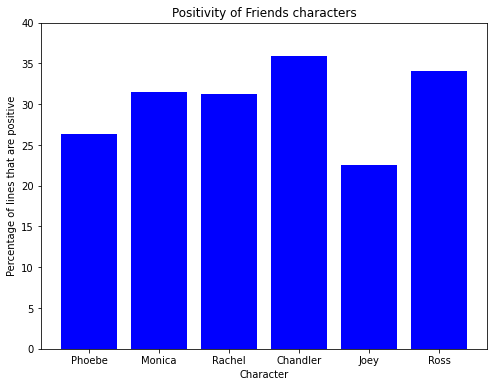

In [13]:
from matplotlib import pyplot as plt

positivity = []
for value in char_sentiment:
    positivity.append(value[1])

plt.figure(figsize=(8, 6))
plt.bar(names, positivity, color = 'b')
plt.ylabel("Percentage of lines that are positive")
plt.xlabel("Character")
plt.title("Positivity of Friends characters")
plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
plt.show()

Well, it looks like Chandler was the most positive. Considering he is known for his sarcasm it surprises me that he was the most positive character in the first episode.
It is also extremely surprising that Joey is the least positive character, nearly 4 percentage points lower than Phoebe, the next least positive character, and over 13 percentage points lower than Chandler.

**Conclusion**

In the first ever episode of Friends Chandler is the most positive character while Joey is the least positive character.

Potentially in a future notebook I will repeat the above analysis for the final ever episode and find out whether these findings have changed.

If you have any other suggestions for future analyses please leave them as a comment here on Kaggle.

Thanks for reading, hope you enjoyed it!